#  Linear classification, multi class based on a 2D (2 features) problem

Following the binary (2 class) classification ([HTML](ClassificationContinuous2Features-Keras.html) / [Jupyter](ClassificationContinuous2Features-Keras.ipynb)), let's generalize to more classes.

Two models generated datasets are used : based on the Czech Republic and Norway flags. Both have three colors corresponding to the three classes we want to separate. The Czech flag is linearly separable, the Norway's one is not. 

Learning goals :
- Multiclass classification with softmax activation
- Multilayer neural network to handle not linear functions
- Use regularization to improve score and convergence

In [1]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as pltcolors
from sklearn import metrics as skMetrics
import pandas
import seaborn as sns

In [2]:
usingTensorBoard = False

## Helpers

In [3]:
# Helper to plot the flag as a 2D parametric label
def flagPlot(x0, x1, y, title, colors):
    ax = plt.gca()
    ax.set_facecolor((0.8, 0.8, 0.8))
    plt.scatter(x0, x1, c=y, cmap=pltcolors.ListedColormap(colors), marker='x', alpha=0.5);
    plt.xlabel('x0')
    plt.ylabel('x1')
    plt.grid()
    plt.title(title)
    cb = plt.colorbar()
    loc = np.arange(0,2.1,1)
    cb.set_ticks(loc)
    cb.set_ticklabels([0,1,2]);
    
def plotHeatMap(X, classes, title=None, fmt='.2g', ax=None, xlabel=None, ylabel=None):
    """ Fix heatmap plot from Seaborn with pyplot 3.1.0, 3.1.1
        https://stackoverflow.com/questions/56942670/matplotlib-seaborn-first-and-last-row-cut-in-half-of-heatmap-plot
    """
    ax = sns.heatmap(X, xticklabels=classes, yticklabels=classes, annot=True, fmt=fmt, cmap=plt.cm.Blues, ax=ax) #notation: "annot" not "annote"
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    if title:
        ax.set_title(title)
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)
        
def plotConfusionMatrix(yTrue, yEst, classes, title=None, fmt='.2g', ax=None):
    plotHeatMap(skMetrics.confusion_matrix(yTrue, yEst), classes, title, fmt, ax, xlabel='Estimations', ylabel='True values');

## Czech flag split of the 2D plan

Let's use the Czech flag as a  pattern to fit with a 3 class linear regression.
Czech flag is made of three areas which are separated by segments. It should be separable with linear boundaries.

### Data model for the Czech flag

In [4]:
# Czech flag colors
czechColors = np.array(['blue', 'red', 'white'])
nFeatures = 2
nClasses = 3
# Generate a multi class sample based on the Czech banner geometry. Tip of the triangle if at the origin
def generateCzechBatch(n, noiseSigma=0.1):
    # xMax adjusted such that the 3 classes are quasi equiprobable
    xMin = np.array([-1, -1])
    xMax = np.array([0.5, 1])
    #
    X = np.random.uniform(xMin, xMax, (n, nFeatures))
    noisyX = X + np.random.normal(0, noiseSigma, X.shape)
    y = np.zeros(n)
    y[noisyX[:,1] > 0]  = 2                                       # White
    y[noisyX[:,1] <= 0] = 1                                       # Red
    y[(noisyX[:,0] <= 0) & (np.abs(noisyX[:,1]) < np.abs(noisyX[:,0]))] = 0 # Blue triangle
    return X, y

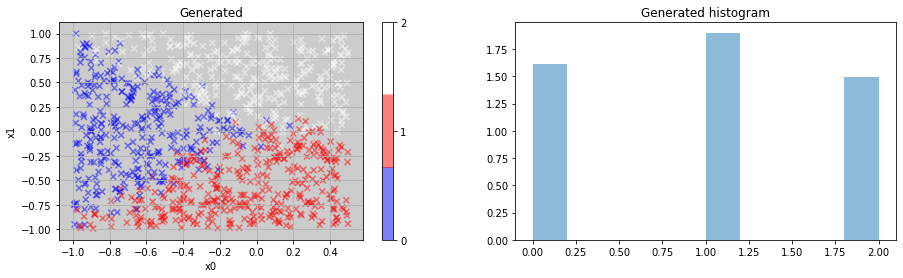

In [5]:
N = 1000
xTrain, yTrain = generateCzechBatch(N)
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
flagPlot(xTrain[:,0], xTrain[:,1], yTrain, 'Generated', czechColors)
plt.subplot(1,2,2)
plt.hist(yTrain, 10, density=True, alpha=0.5)
plt.title('Generated histogram');

### Test data

In [6]:
xTest, yTest = generateCzechBatch(N)

## Softmax regression

Maximum a posteriori with softmax is the generalization of the logistic regression in case number of classes is greater than 2.

The softmax will normalize the set of output values to a sum of 1, outputs are then probabilities.

With K the number of classes:
\begin{align}
y \in \left\{ 1 ... K \right\}
\end{align}

The softmax probability law of Y is:
\begin{align}
p (Y=c \mid x, w) & = \frac{e^{w_{c} x }}{\sum_{j=1}^{K}e^{w_{j} x}} 
\end{align}

We are looking for the value of w that maximizes the likelyhood:
\begin{align}
\hat{w} & = \arg \max_{w}{\prod_{i=0}^N{p(y_i \mid  x_i, w)}} \\
& =  \arg \max_{w}{\sum_{i=0}^N{\log \bigl(p(y_i \mid x_i, w)\bigr)} } \\
& =  \arg \max_{w}{\sum_{c=1}^K\sum_{i=0}^N{\mathbb{1}_{y_i=c} * \log \biggl(\frac{e^{w_{c} x }}{\sum_{j=1}^{K}e^{w_{j} x}} \biggr)} } \\
\end{align}

Where $\mathbb{1}_{y_i=c}$ is the indicator function which takes value 1 if $y_i=c$ and 0 otherwise

When using an iterative gradient descent, the __cost function__ is then defined as:
\begin{align}
J_w = - \sum_{c=1}^K\sum_{i=0}^N{\mathbb{1}_{y_i=c} * \log \biggl(\frac{e^{w_{c} x }}{\sum_{j=1}^{K}e^{w_{j} x}}\biggr)}
\end{align}

Reference:
- https://en.wikipedia.org/wiki/Multinomial_logistic_regression
- http://deeplearning.stanford.edu/tutorial/supervised/SoftmaxRegression/


## Using Keras with TensorFlow backend

### Gradient descent with softmax output using Keras

Keras is used as a single layer of perceptron with softmax activation.

References:
- https://www.kaggle.com/pierrek20/multiclass-iris-prediction-with-tensorflow-keras

The simplest model of linear regression is based on a single layers with as many neurons as the number of classes (=3). The activation of the layer is a softmax taking reference values (y/label train) in range \[0,3)

In [7]:
# Number of epochs
nEpoch = 1024
nBatch = 128 # 32 is default

# Model
model0 = keras.models.Sequential([
  keras.layers.Dense(nClasses, activation=keras.activations.softmax, 
                     kernel_regularizer=keras.regularizers.l1(0.001),
                     input_shape=[nFeatures])
])
model0.compile(optimizer='adam',
              loss=keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

# Tensor board display
callbacks = []
if usingTensorBoard:
    ks = keras.callbacks.TensorBoard(log_dir="./logs/", histogram_freq=1, write_graph=True, write_grads=True, batch_size=1)
    callbacks = [ks]

# Fit
hist0 = model0.fit(xTrain, yTrain, epochs=nEpoch, batch_size=nBatch, verbose=0, callbacks=callbacks)

In [8]:
weights0, biases0 = model0.get_weights()
print('Est W=', weights0)
print('b=', biases0)

Est W= [[-2.8781772   3.9222672   3.9757454 ]
 [ 0.27168787 -5.429385    6.0552115 ]]
b= [-0.4286471   0.38129994  0.06073063]


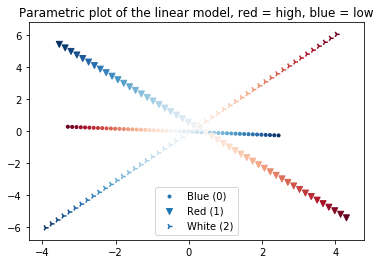

In [9]:
# Parametric plot of the linear model
t = np.linspace(-1, 1)
markers = ('.', 'v', '4')
for i in range(0,3):
    plt.scatter(weights0[0, i] * t + biases0[i], weights0[1, i]*t, marker=markers[i], c=t, cmap="RdBu_r")
plt.legend(['Blue (0)', 'Red (1)', 'White (2)']);
plt.title('Parametric plot of the linear model, red = high, blue = low');

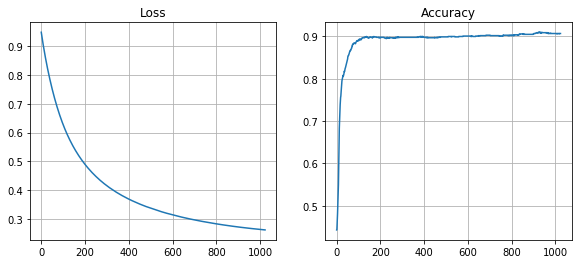

In [10]:
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.plot(hist0.history['loss'])
plt.grid()
plt.title('Loss')
plt.subplot(1,3,2)
plt.plot(hist0.history['accuracy'])
plt.grid()
plt.title('Accuracy');

#### Testing the model

In [11]:
yEst0 = model0.predict(xTest)
labelEst0 = np.argmax(yEst0, axis=1)

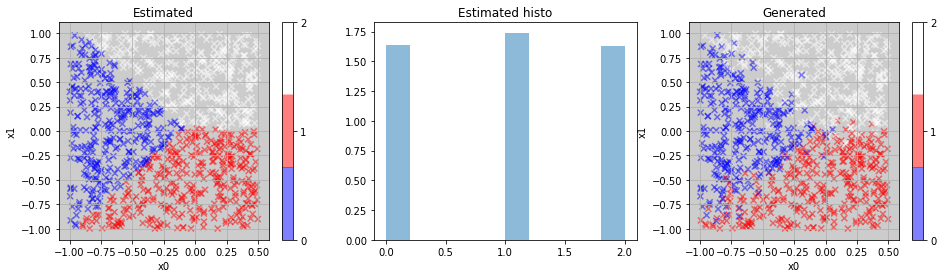

In [12]:
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
flagPlot(xTest[:,0], xTest[:,1], labelEst0, 'Estimated', czechColors)
plt.subplot(1,3,2)
plt.hist(labelEst0, 10, density=True, alpha=0.5)
plt.title('Estimated histo')
plt.subplot(1,3,3)
flagPlot(xTest[:,0], xTest[:,1], yTest, 'Generated', czechColors)

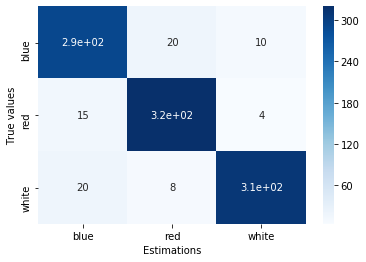

In [13]:
plotConfusionMatrix(yTest, labelEst0, czechColors);

In [14]:
print(skMetrics.classification_report(yTest, labelEst0))

              precision    recall  f1-score   support

         0.0       0.89      0.91      0.90       322
         1.0       0.92      0.94      0.93       339
         2.0       0.96      0.92      0.94       339

    accuracy                           0.92      1000
   macro avg       0.92      0.92      0.92      1000
weighted avg       0.92      0.92      0.92      1000



#### Conclusions on initial model

Fitting is excellent, the separation of the classes is very accurate

Verification is done that the Czech flag is linearly separable.

## Norway flag regression

Norway's flag is more challenging than the Czech one as it contains a double white-blue cross.

Evidently it is not linearly separable. Actualy, this class of problems, the simplest being the XOR truth table, is one motivation to neural networks.

### Data model for the Norway flag

Geometry is modified to get quasi equiprobable categories

In [15]:
# Norway flag colors
norwayColors = ['red', 'white', 'navy']
# Generate a multi class sample based on the Norway banner geometry. 
def generateNorwayBatch(n, noiseSigma=0.1):
    # xMax adjusted such that the 3 classes are quasi equiprobable
    xMin = np.array([-1, -1])
    xMax = np.array([1, 1])
    #
    X = np.random.uniform(xMin, xMax, (n, nFeatures))
    a1 = 0.43
    a2 = 0.18
    noisyX = X + np.random.normal(0, noiseSigma, X.shape)
    y = np.zeros(n)                                                                # Red = background
    y[((noisyX[:,0] > -a1) & (noisyX[:,0] < a1)) | ((noisyX[:,1] > -a1) & (noisyX[:,1] < a1))]  = 1    # White cross
    y[((noisyX[:,0] > -a2) & (noisyX[:,0] < a2)) | ((noisyX[:,1] > -a2) & (noisyX[:,1] < a2))]  = 2    # Navy cross over white
    return X, y

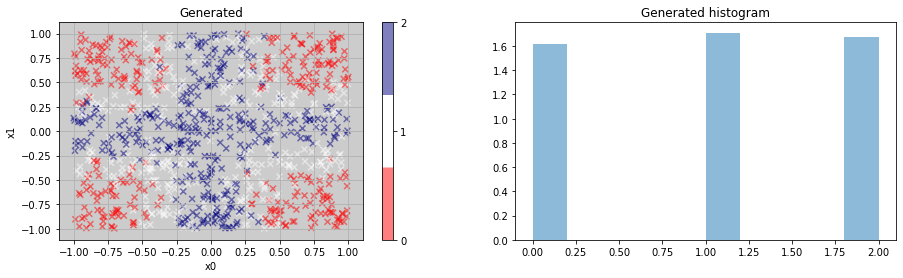

In [16]:
N = 1000
xTrain1, yTrain1 = generateNorwayBatch(N)
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
flagPlot(xTrain1[:,0], xTrain1[:,1], yTrain1, 'Generated', norwayColors)
plt.subplot(1,2,2)
plt.hist(yTrain1, 10, density=True, alpha=0.5)
plt.title('Generated histogram');

### Test data

In [17]:
xTest1, yTest1 = generateNorwayBatch(N)

### Single layer model

In [18]:
nEpoch = 128
nBatch = 128

# Model
model1 = keras.models.Sequential([
  keras.layers.Dense(nClasses, activation=keras.activations.softmax, input_shape=[nFeatures],
                    kernel_regularizer=keras.regularizers.l1(0.001))
])
model1.compile(optimizer='adam',
              loss=keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

# Fit single layer model on Norway data
hist1 = model1.fit(xTrain1, yTrain1, epochs=nEpoch, batch_size=nBatch, verbose=0, callbacks=callbacks)

In [19]:
weights1, biases1 = model1.get_weights()
print('Est W=', weights1)
print('b=', biases1)

Est W= [[-0.38265452 -0.40274367 -0.5217999 ]
 [ 0.08239781 -0.30017456  0.03173269]]
b= [-0.025961    0.01384929  0.00867589]


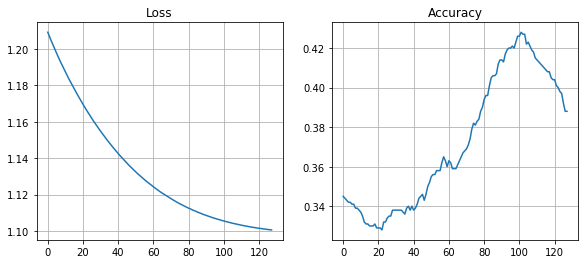

In [20]:
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.plot(hist1.history['loss'])
plt.grid()
plt.title('Loss')
plt.subplot(1,3,2)
plt.plot(hist1.history['accuracy'])
plt.grid()
plt.title('Accuracy');

#### Testing the model

In [21]:
yEst1 = model1.predict(xTest1)
labelEst1 = np.argmax(yEst1, axis=1)

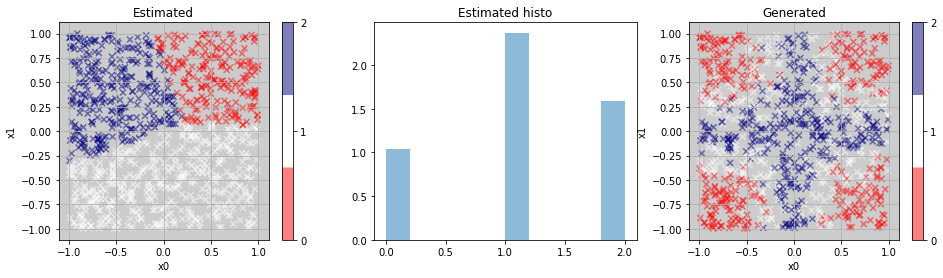

In [22]:
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
flagPlot(xTest1[:,0], xTest1[:,1], labelEst1, 'Estimated', norwayColors)
plt.subplot(1,3,2)
plt.hist(labelEst1, 10, density=True, alpha=0.5)
plt.title('Estimated histo')
plt.subplot(1,3,3)
flagPlot(xTest1[:,0], xTest1[:,1], yTest1, 'Generated', norwayColors)

As expected, the linear model is not able to separate the classes.

### Two layer model on Norway

In [23]:
nEpoch = 512
nBatch = 128

# Model
model2 = keras.models.Sequential([
    keras.layers.Dense(16, activation=keras.activations.relu, input_shape=[nFeatures],
                        kernel_regularizer=keras.regularizers.l1(0.001),
                        bias_regularizer=keras.regularizers.l1(0.001)),
    keras.layers.Dense(nClasses, activation=keras.activations.softmax,
                      kernel_regularizer=keras.regularizers.l1(0.0001))
])
model2.compile(optimizer='adam',
              loss=keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

# Fit two layer model on Norway data
hist2 = model2.fit(xTrain1, yTrain1, epochs=nEpoch, batch_size=nBatch, verbose=0, callbacks=callbacks)

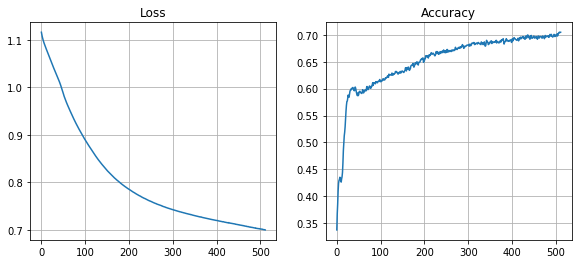

In [24]:
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.plot(hist2.history['loss'])
plt.grid()
plt.title('Loss')
plt.subplot(1,3,2)
plt.plot(hist2.history['accuracy'])
plt.grid()
plt.title('Accuracy');

#### Testing the model

In [25]:
yEst2 = model2.predict(xTest1)
labelEst2 = np.argmax(yEst2, axis=1)

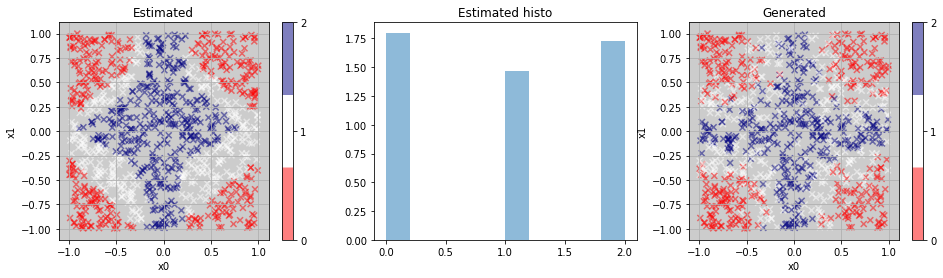

In [26]:
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
flagPlot(xTest1[:,0], xTest1[:,1], labelEst2, 'Estimated', norwayColors)
plt.subplot(1,3,2)
plt.hist(labelEst2, 10, density=True, alpha=0.5)
plt.title('Estimated histo')
plt.subplot(1,3,3)
flagPlot(xTest1[:,0], xTest1[:,1], yTest1, 'Generated', norwayColors)

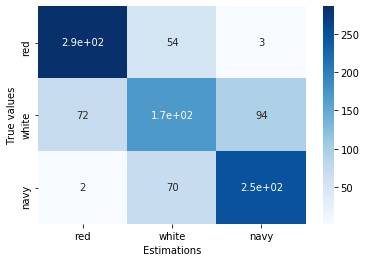

In [27]:
plotConfusionMatrix(yTest1, labelEst2, norwayColors);

The two layer neural network is improving compared to the single layer (linear) model. 

Accuracy is greatly improved ranging from ~60% to 95% depending on the fitting convergence

In [28]:
print(skMetrics.classification_report(yTest1, labelEst2))

              precision    recall  f1-score   support

         0.0       0.79      0.83      0.81       343
         1.0       0.58      0.51      0.54       336
         2.0       0.72      0.78      0.75       321

    accuracy                           0.70      1000
   macro avg       0.70      0.71      0.70      1000
weighted avg       0.70      0.70      0.70      1000



### Three layer  neural network on Norway

In [29]:
nEpoch = 512
nBatch = 128

# Model
model3 = keras.models.Sequential([
    keras.layers.Dense(8, activation=keras.activations.linear, input_shape=[nFeatures],
                        kernel_regularizer=keras.regularizers.l1(0.001),
                        bias_regularizer=keras.regularizers.l1(0.001)),
    keras.layers.Activation(keras.activations.relu),
    keras.layers.Dense(8, activation=keras.activations.linear,
                       kernel_regularizer=keras.regularizers.l1(0.001),
                       bias_regularizer=keras.regularizers.l1(0.001)),
    keras.layers.Activation(keras.activations.relu),
    keras.layers.Dense(nClasses, activation=keras.activations.softmax)
])
model3.compile(optimizer='adam',
              loss=keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

# Fit on Norway data
hist3 = model3.fit(xTrain1, yTrain1, epochs=nEpoch, batch_size=nBatch, verbose=0, callbacks=callbacks)

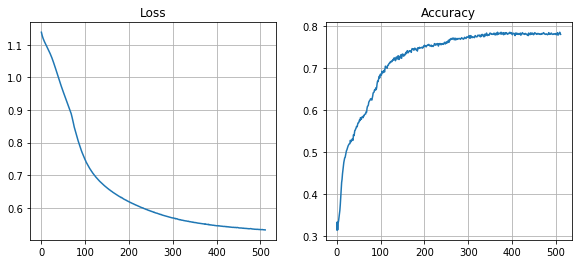

In [30]:
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.plot(hist3.history['loss'])
plt.grid()
plt.title('Loss')
plt.subplot(1,3,2)
plt.plot(hist3.history['accuracy'])
plt.grid()
plt.title('Accuracy');

#### Testing the model

In [31]:
yEst3 = model3.predict(xTest1)
labelEst3 = np.argmax(yEst3, axis=1)

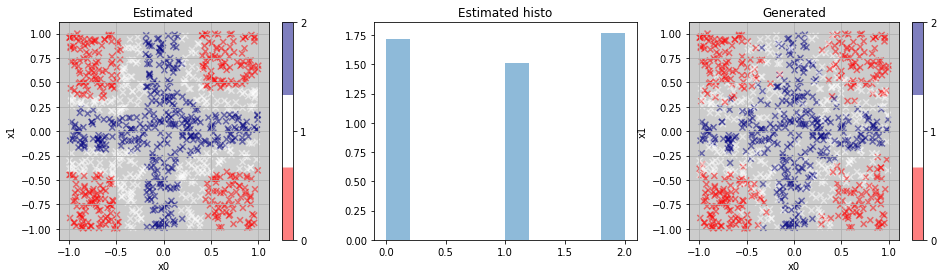

In [32]:
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
flagPlot(xTest1[:,0], xTest1[:,1], labelEst3, 'Estimated', norwayColors)
plt.subplot(1,3,2)
plt.hist(labelEst3, 10, density=True, alpha=0.5)
plt.title('Estimated histo')
plt.subplot(1,3,3)
flagPlot(xTest1[:,0], xTest1[:,1], yTest1, 'Generated', norwayColors)

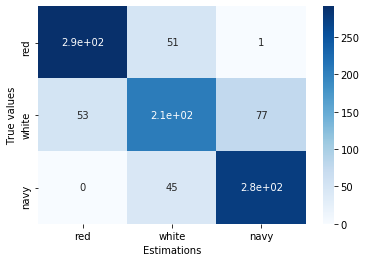

In [33]:
plotConfusionMatrix(yTest1, labelEst3, norwayColors);

In [34]:
print(skMetrics.classification_report(yTest1, labelEst3))

              precision    recall  f1-score   support

         0.0       0.85      0.85      0.85       343
         1.0       0.68      0.61      0.65       336
         2.0       0.78      0.86      0.82       321

    accuracy                           0.77      1000
   macro avg       0.77      0.77      0.77      1000
weighted avg       0.77      0.77      0.77      1000



The three layer neural network is improving the accuracy and F1-score

A large added value of the (deep) neural net is shown... at the expense of a much more complex model:

In [35]:
weights3 = model3.get_weights()
model3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 8)                 24        
_________________________________________________________________
activation (Activation)      (None, 8)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 72        
_________________________________________________________________
activation_1 (Activation)    (None, 8)                 0         
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 27        
Total params: 123
Trainable params: 123
Non-trainable params: 0
_________________________________________________________________


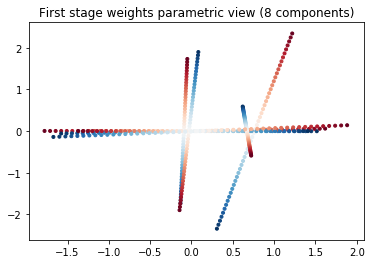

In [36]:
t = np.linspace(-1, 1)
width3_1 = len(weights3[1])
for i in range(0,width3_1):
    plt.scatter(weights3[0][0, i] * t + weights3[1][i], weights3[0][1, i] * t, marker='.', c=t, cmap="RdBu_r")
plt.title('First stage weights parametric view ({:d} components)'.format(width3_1));

The direction graph above is showing that the two main directions (along axes) are identified by the learnt features of the neural network using pairs of neurons (one for each direction). Some other neurons are used within the top left quadrant.

In [37]:
weights3[0]

array([[-1.6474309e+00,  4.1438375e-02, -1.1377184e-01,  1.5975128e+00,
         4.5577183e-01, -1.3892711e+00,  5.1281884e-02,  1.7773986e+00],
       [ 3.3753177e-03,  1.7328085e+00, -1.8991382e+00,  5.9235338e-02,
         2.3455155e+00,  8.3160086e-04, -5.8959264e-01,  1.4065911e-01]],
      dtype=float32)

## Where to go from here

- Same multi-class classification problem solved with Decision Trees ([HTML](ClassificationMulti2Features-Tree.html) / [Jupyter](ClassificationMulti2Features-Tree.ipynb))